In [101]:
from Chemometrics.mass_utils import iso_dist,composition2formula
from Chemometrics.basic import to_sheets, psave
from pyteomics.mass.mass import Composition,nist_mass,calculate_mass
import glob
import heapq
import inspect
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import Chemometrics
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']

In [45]:
print(inspect.getsource(Chemometrics.mass_utils.filter_nist))

def filter_nist(isotopes, threshold=1e-5):
    """
    过滤prob小于threshold（1e-4）的元素同位素
    """

    _isotopes = {isotopes[m] for m in isotopes if m > 0 and isotopes[m][1] > threshold}
    return _isotopes



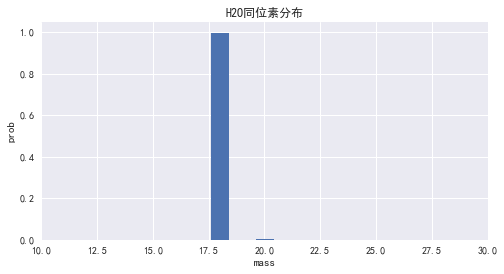

In [107]:
a = pd.Series(iso_dist(Composition('H2O'), k=20, ethresshold=0)).reset_index()
plt.figure(figsize=(8,4))
plt.bar(a.loc[:,'index'], a.loc[:, 0])
plt.xlim((10,30))
plt.title('H2O同位素分布')
plt.xlabel('mass')
plt.ylabel('prob')
plt.savefig('H2O.png', dpi=300)

In [52]:
Chemometrics.mass_utils.filter_nist(nist_mass['O']), Chemometrics.mass_utils.filter_nist(nist_mass['H'])

({(15.99491461956, 0.99757), (16.9991317, 0.00038), (17.999161, 0.00205)},
 {(1.00782503207, 0.999885), (2.0141017778, 0.000115)})

In [8]:
Na = nist_mass['Na'][0][0]
def e_formula(str_formula):
    """
    将formula表示为元素数目， 而不是其他code
    :param str_formula:
    :return:
    """
    any_digit = any(c.isdigit() for c in str_formula)
    if not any_digit:
        str_formula += '1'
    return str_formula
def topk_value(dict_, k=5):
    """
    取出dict中较大的k个元素
    """
    mw_prob = ((m, dict_[m]) for m in heapq.nlargest(k, dict_, key=dict_.get))
    return mw_prob
def _charge_add(mw_prob, num_adds=(1,2), add=Na, charge_add=1):
    """
    多电荷
    columns = ('m'+str(m)+'z'+str(z) for z in range(1,3) for m in range(1,6))
    """
    mw, prob = zip(*mw_prob)
    _mw = (tuple(map(lambda x: (n * add + x)/(n * charge_add), mw)) for n in num_adds) #vectorization, conceptially clear, python single thread
    _mw = reduce(lambda x, y: x+y, _mw)
    prob = tuple(p/prob[0] for p in prob)
    return _mw + prob
    
def _iso_k(formula, k=5):
    _iso_dist = iso_dist(Composition(e_formula(formula)))
    _iso_dist_avg = avg_iso(_iso_dist).sort_values(ascending=False).to_dict()
    entry = _charge_add(topk_value(_iso_dist_avg, k))
    return entry
def avg_iso(iso_dist):
    """
    iso_dist: dict
    """
    a = pd.Series(iso_dist)
    _result = a.groupby(a.index.values.round()).apply(_weight_mean).reset_index().drop(['level_0'], axis=1).set_index('level_1').loc[:,0]
    #_result = _result.sort_values(ascending=False)
    return _result
def _weight_mean(x):
    mz = x.index.values
    w = x.values
    w_sum = w.sum()
    w = w/w_sum
    _mz = mz.dot(w)
    return pd.Series([w_sum], index=[_mz])

In [3]:
columns = ['m'+str(m)+'z'+str(z) for z in range(1,3) for m in range(1,6)] + ['p'+str(p) for p in range(1,6)]
def _iso(df):
    _dict = df.to_dict(orient='index')
    _isos ={n: _iso_k(composition2formula(_dict[n])) for n in _dict}
    _df = pd.DataFrame.from_dict(_isos, orient='index')
    _df.columns = columns
    _df = df.reset_index().merge(_df, how='right', left_on='聚合度n', right_index=True)
    return _df

In [14]:
#test
files = glob.glob('TW*分子式_数值版.xlsx')
dfs = pd.read_excel(files[0], index_col='聚合度n', sheetname=None)
_iso(dfs['TW20_A-1']).tail()

,聚合度n,C,H,O,m1z1,m2z1,m3z1,m4z1,m5z1,m1z2,m2z2,m3z2,m4z2,m5z2,p1,p2,p3,p4,p5
57,57,120,240,62,2697.555913,2698.559021,2696.552483,2699.561989,2700.564860,1360.272841,1360.774395,1359.771126,1361.275879,1361.777315,1.0,0.763762,0.741231,0.423683,0.188629
58,58,122,244,63,2741.582128,2742.585240,2740.578698,2743.588213,2744.591089,1382.285949,1382.787505,1381.784234,1383.288991,1383.790429,1.0,0.774954,0.729086,0.435816,0.196591
59,59,124,248,64,2785.608343,2786.611460,2784.604913,2787.614437,2788.617318,1404.299056,1404.800614,1403.797341,1405.302103,1405.803544,1.0,0.786145,0.717333,0.448117,0.204768
60,60,126,252,65,2829.634557,2830.637679,2828.631128,2831.640661,2832.643546,1426.312163,1426.813724,1425.810448,1427.315215,1427.816658,1.0,0.797339,0.705953,0.460584,0.213165
61,61,128,256,66,2873.660772,2874.663898,2872.657342,2875.666885,2876.669774,1448.325271,1448.826834,1447.823556,1449.328327,1449.829772,1.0,0.808534,0.694928,0.473217,0.221782


In [5]:
files = glob.glob('TW*分子式_数值版.xlsx')
for f in files:
    dfs = pd.read_excel(f, index_col='聚合度n', sheetname=None)
    df_dict = {df: _iso(dfs[df]) for df in dfs}
    to_sheets(df_dict, '_'+f)

In [20]:
psave(df_dict, '同位素库.p')